# Light


In [ ]:
import tensorflow
print(tensorflow.__version__)
print("Tensorflow compiled with CUDA support:", tensorflow.test.is_built_with_cuda())
print(tensorflow.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))
print(tensorflow.config.list_physical_devices('GPU'))

device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

2.7.0
Tensorflow compiled with CUDA support: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found GPU at: /device:GPU:0
Tue Nov  9 22:14:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    35W / 250W |    375MiB / 16280MiB |      0%      Default |
|                

In [1]:
import os
import sys

def prepare_dev_stationary():

    global DEV
    global DEV_DATA
    try:
        test_ipython = str(get_ipython())
    except NameError:
        print('Running on local environment')
        DEV = os.getcwd()
    else:
        if 'google.colab' in test_ipython:
            print('Running on CoLab')
            from google.colab import drive
            drive.mount('/content/drive')
            cmd = "pip install -U keras-tuner"
            os.system(cmd)
            DEV = '/content/drive/MyDrive/Python/sunday'
        elif 'ipykernel' in test_ipython:
            print('Running on Jupyter Notebook')
            DEV = os.getcwd()
    sys.path.append(DEV)
    path_head = os.path.split(DEV)[0]
    DEV_DATA = os.path.join(path_head, 'sunday_show/')
    pass

prepare_dev_stationary()
print(DEV)
print(DEV_DATA)
import keras_tuner
print(keras_tuner.__version__)

Running on Jupyter Notebook
/home/cubecloud/Python/projects/sunday_show
/home/cubecloud/Python/projects/sunday_show/
1.0.3


## Временные ряды - Dense
Dense

In [2]:
# import os
# import sys
import pytz
# from keykeeper import Keeper

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.activations import exponential
from tensorflow.keras.activations import selu
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.layers import MaxPool1D, AvgPool1D, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.layers import ReLU, LeakyReLU, ELU
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import utils
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
import matplotlib.pyplot as plt
import seaborn as sns

# Рисовать графики сразу же
%matplotlib inline

timezone = pytz.timezone("Europe/Moscow")
__version__ = 0.0004

In [ ]:
data_path = f"{DEV_DATA}"

def get_symbol_interval_data(pair_symbol, time_interval="1m"):
    """
    Loading currency trading data from file
    """
    # pairs_data_path = os.path.join(Keeper.get_data_folder_path(), "pairs_data")
    pairs_data_path = os.path.join(data_path, "pairs_data")
    data_df = pd.read_csv(os.path.join(pairs_data_path, f"{pair_symbol}-{time_interval}-data.csv"))
    print(data_df.head(5).to_string())

    temp_index = pd.to_datetime(data_df['timestamp'])

    # data_df = data_df.drop(columns=["timestamp", "close_time", "quote_av", "tb_base_av", "tb_quote_av", "ignore"])
    """
    !!!
    Removed "trades" column for test
    !!!
    """
    data_df = data_df.drop(columns=["timestamp", "close_time", "quote_av", "tb_base_av", "tb_quote_av", "ignore", "trades"])
    data_df.index, data_df.index.name = temp_index, "datetimeindex"
    # data_df.index = data_df.index.tz_localize(timezone)
    return data_df
    
"""
Lukoil base
""" 
def get_lukoil_base():
    test_data_path = os.path.join(data_path, "test_data")
    base_data16 = pd.read_csv(os.path.join(test_data_path,'lukoil/16_17.csv'), sep=';')
    base_data18 = pd.read_csv(os.path.join(test_data_path,'lukoil/18_19.csv'), sep=';')

    data16_17 = base_data16.iloc[:,2:]
    data18_19 = base_data18.iloc[:,2:]
    data = data16_17.copy()                 
    data_df = pd.concat([data16_17, data18_19])
    return data_df


In [ ]:
# data_df = get_lukoil_base() 
interval = "1m"
"""
Warning! Getting only last half/year data 525,600/2=262800 minutes


"""
data_df = get_symbol_interval_data("ETHUSDT", f"{interval}")[-262800:]
# pct_df = data_df.pct_change()
print(data_df.shape)
data_df.tail(10)

             timestamp    open    high     low   close   volume     close_time    quote_av  trades  tb_base_av  tb_quote_av        ignore
0  2017-08-17 04:00:00  301.13  301.13  301.13  301.13  0.42643  1502942459999  128.410866       2     0.42643   128.410866  46530.510646
1  2017-08-17 04:01:00  301.13  301.13  301.13  301.13  2.75787  1502942519999  830.477393       4     2.75787   830.477393  46530.510646
2  2017-08-17 04:02:00  300.00  300.00  300.00  300.00  0.09930  1502942579999   29.790000       2     0.09930    29.790000  46530.510646
3  2017-08-17 04:03:00  300.00  300.00  300.00  300.00  0.31389  1502942639999   94.167000       3     0.00000     0.000000  46530.510646
4  2017-08-17 04:04:00  301.13  301.13  301.13  301.13  0.23202  1502942699999   69.868183       1     0.23202    69.868183  46530.963646
(262800, 5)


,open,high,low,close,volume
datetimeindex,,,,,
2021-11-02 14:13:00,4470.10,4470.10,4463.16,4466.03,664.5650
2021-11-02 14:14:00,4466.04,4468.03,4465.39,4465.61,384.9971
2021-11-02 14:15:00,4465.61,4467.17,4460.29,4461.50,909.2677
2021-11-02 14:16:00,4461.49,4462.02,4454.49,4460.14,884.0222
2021-11-02 14:17:00,4460.14,4467.86,4460.00,4467.86,244.0259
2021-11-02 14:18:00,4467.85,4473.54,4467.23,4473.48,444.2826
2021-11-02 14:19:00,4473.49,4473.49,4467.42,4472.54,201.3358
2021-11-02 14:20:00,4472.53,4477.17,4472.08,4475.78,595.1533
2021-11-02 14:21:00,4475.78,4475.81,4473.96,4475.20,207.2385


(262800, 5)


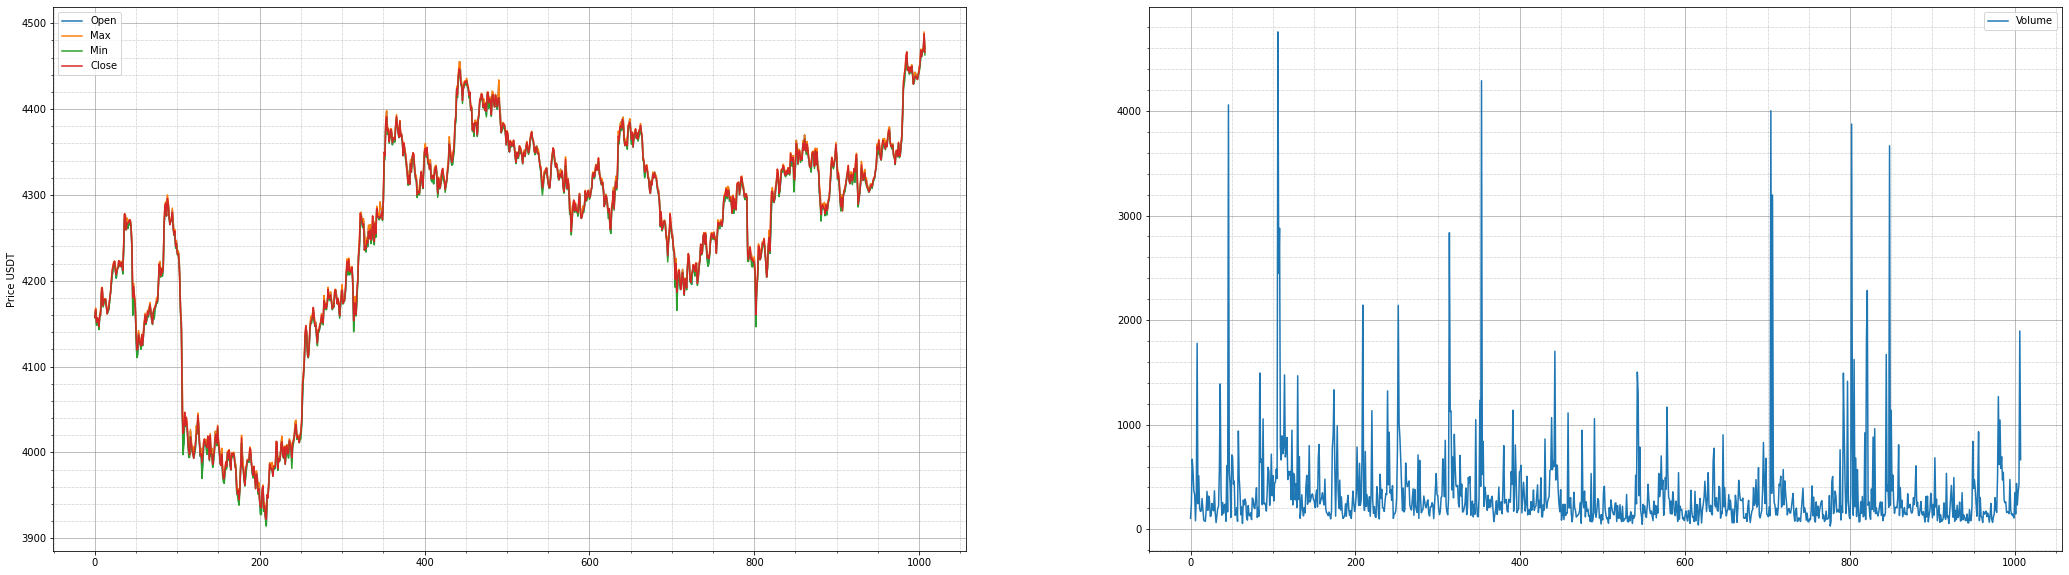

In [ ]:
"""
Checking data and visualize
"""
data = np.array(data_df)
print(data.shape)                   #Отображаем исходные от точки start и длинной step
end_points = data.shape[0]          #How many points from start to draw
start_points = end_points - 10080   # Get 60*60*24=1440 (24h) 1440*7=10080 (7 days)
step_points = 10                 #how many points step

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#ЧЕтыре основных канала - open, max, min, close
fig = plt.figure(figsize=(36,10))
# gs = fig.add_gridspec(2, 1)
ax1 = fig.add_subplot(1, 2, 1)
# Don't allow the axis to be on top of your data
ax1.set_axisbelow(True)
# Turn on the minor TICKS, which are required for the minor GRID
ax1.minorticks_on()
# Customize the major grid
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
# Customize the minor grid
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
for i in range(4):
    #Отрисовываем часть данных
    #От начальной точки, до начальной точки + размер шага отрисовки
    plt.plot(data[start_points:start_points+end_points:step_points, i], 
              label=chanelNames[i])
plt.ylabel('Price USDT')
plt.legend()

#Канал volume
ax1 = fig.add_subplot(1, 2, 2)
# Don't allow the axis to be on top of your data
ax1.set_axisbelow(True)
# Turn on the minor TICKS, which are required for the minor GRID
ax1.minorticks_on()
# Customize the major grid
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
# Customize the minor grid
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.plot(data[start_points:start_points+end_points:step_points,4], label="Volume")
plt.legend()
plt.show()

#### Main class TechnoBuild

In [ ]:
#Формируем параметры загрузки данных
class TechnoBuild():
    # def __init__(self, directory, project_name, xLen=300, valLen=30000, trials=20):
    def __init__(self, data, directory, project_name, xLen=300, valLen=30000, trials=20, stride=1, batch_size=128, speedup_data=False):
        self.alldata_df = data
        self.directory = directory
        self.project_name = project_name
        self.xLen = xLen                        #Analyzing slice length
        self.valLen = valLen                    #Length of data for validation
        self.MAX_TRIALS = trials
        self.stride = stride
        self.batch_size = batch_size
        self.speedup_data = speedup_data        #Use it for preparing all dataset and load it in memory -> True. Default: False

        self.base_cols = self.alldata_df.columns.to_list()[:5]
        self.all_cols = self.alldata_df.columns.to_list()
        # print(self.base_cols)
        # print(self.all_cols)
        self.selected_cols = self.base_cols.copy()
        if self.alldata_df.shape[1] > 5:
            print(self.alldata_df.shape)
            self.bigdata = True
            self.sub_cols = [col for col in self.all_cols if (col.startswith('sub_')) and (not col.startswith('abs_'))]
            self.abs_cols = [col for col in self.all_cols if col.startswith('abs_')]
            self.mul_cols = [col for col in self.all_cols if col.startswith('mul_')]
            self.dx_cols = [col for col in self.all_cols if col.startswith('dx')]
            self.bck_cols = [col for col in self.all_cols if col.startswith('bck')]
            self.stack = []
            self.stack.append(self.sub_cols)
            self.stack.append(self.abs_cols)
            self.stack.append(self.mul_cols)
            self.stack.append(self.bck_cols)
            self.stack.append(self.dx_cols)
            self.stack.append(self.bck_cols)
        self.dataset_ready = False
        self.EXECUTIONS_PER_TRIAL = 2
        self.EPOCHS = 50
        self.PATIENCE = 10
        self.xTrain_generated = []
        self.yTrain_generated = []
        self.xTest_generated = []
        self.yTest_generated = []
        self.createdataset()
    pass

    def choose_cols_data(self, hp_cols_lst):
        self.selected_cols = self.base_cols.copy()
        self.selected_cols.extend(hp_cols_lst)
        self.dataset_ready = False
        pass

    def createdataset(self):
        data = np.array(self.alldata_df.loc[:, self.selected_cols])
        self.trainLen = data.shape[0]-self.valLen # Размер тренировочной выборки
        #Делим данные на тренировочную и тестовую выборки 
        self.xTrain_unscaled, self.xTest_unscaled = data[:self.trainLen], data[self.trainLen+self.xLen+2:]
        print(f'x_train: {self.xTrain_unscaled.shape}, x_test {self.xTest_unscaled.shape}')
        # print(f'y_data: {data[0:5, 3]}')
        # print(f'x_data: {data[0:5, :]}')
        # print(self.alldata_df.iloc[0:5, :])

        #Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
        self.xScaler = MinMaxScaler()
        self.xScaler.fit(self.xTrain_unscaled)
        self.xTrain = self.xScaler.transform(self.xTrain_unscaled)
        self.xTest = self.xScaler.transform(self.xTest_unscaled)

        # Делаем reshape,т.к. у нас только один столбец по одному значению
        # Using only "close" data for Y - column = 3 
        self.yTrain_unscaled, self.yTest_unscaled = np.reshape(data[:self.trainLen,3],(-1,1)), np.reshape(data[self.trainLen+self.xLen+2:,3],(-1,1)) 
        self.yScaler = MinMaxScaler()
        self.yScaler.fit(self.yTrain_unscaled)
        self.yTrain = self.yScaler.transform(self.yTrain_unscaled)
        self.yTest = self.yScaler.transform(self.yTest_unscaled)
        self.tsgenerator(BATCH_SIZE=self.batch_size)
        pass


    def traingen(self, BATCH_SIZE):
        #Создаем генератор для обучения
        self.trainDataGen = TimeseriesGenerator(self.xTrain, self.yTrain,       #В качестве параметров наши выборки
                                                length=self.xLen, 
                                                stride=self.stride,             #Для каждой точки (из промежутка длины self.xLen)
                                                batch_size=BATCH_SIZE)          #Размер batch, который будем скармливать модели
        pass

    def testgen(self, BATCH_SIZE):
         #Создаем аналогичный генератор для валидации при обучении
        self.testDataGen = TimeseriesGenerator(self.xTest, self.yTest,
                                               length=self.xLen, 
                                               stride=self.stride,
                                               batch_size=BATCH_SIZE)
        pass


    # TODO: create option to have static data for keras_tuner to speedup process

    def tsgenerator(self, BATCH_SIZE=128):
        if self.speedup_data:
            """
            Generate all dataset and allocate all dataset parts in memory
            """
            self.traingen(BATCH_SIZE=len(self.xTrain))
            for batch in self.trainDataGen:
                self.xTrain_generated.append(batch[0])
                self.yTrain_generated.append(batch[1])
            self.xTrain_generated = np.asarray(self.xTrain_generated).squeeze()
            self.yTrain_generated = np.asarray(self.yTrain_generated).squeeze()

            self.testgen(BATCH_SIZE=len(self.xTest))
            for batch in self.testDataGen:
                self.xTest_generated.append(batch[0])
                self.yTest_generated.append(batch[1])
            self.xTest_generated = np.array(self.xTest_generated).squeeze()
            self.yTest_generated = np.array(self.yTest_generated).squeeze()
            self.speedup_data = True
            print("Checking xTrain_generated length", len(self.xTrain_generated))
            print("Checking xTrain_generated shape", self.xTrain_generated.shape)
            print("Checking xTest_generated length", len(self.xTest_generated))
            print("Checking xTest_generated shape", self.xTest_generated.shape)
            print("Checking yTrain_generated length", len(self.yTrain_generated))
            print("Checking yTrain_generated shape", self.yTrain_generated.shape)
            print("Checking yTest_generated length", len(self.yTest_generated))
            print("Checking yTest_generated shape", self.yTest_generated.shape)

        """
        Initialize generators again
        """
        self.traingen(BATCH_SIZE)
        self.testgen(BATCH_SIZE)

        self.dataset_ready = True
        print("Checking generators batch length", len(self.trainDataGen[0][0]))
        print("Checking generators batch shape", self.trainDataGen[0][0].shape)
        pass

    def build_model(self, hp):
        hp.Choice('num_layers', values=[1, 2, 3], default = 1)
        if not self.dataset_ready:
            self.createdataset ()
        model = Sequential()
        # print(f'Train shape: {self.trainDataGen[0][0].shape[1]}, {self.trainDataGen[0][0].shape[2]}')
        model.add(Input(shape = (self.xLen, self.trainDataGen[0][0].shape[2])))
        for i in range(1, hp.get('num_layers')):
            model.add(Dense(units=hp.Int(f'layer_{i}', 
                                         min_value=10,   
                                         max_value=400,   
                                         default=100,
                                         step=10),
                            activation=hp.Choice(f'activation_{i}', 
                                                 values=['relu', 'elu', 'linear']),
                            name = f'dense_layer_{i}')
                     )

        if hp.Choice(f'if_dropout_last', [0, 1], default=1) == 1:
            model.add(Dropout(rate=hp.Float(f'dropout_last',
                                            min_value=0.05,
                                            max_value=0.5,
                                            default=0.25,
                                            step=0.05,
                                           )
                             )
                     )
        model.add(Flatten()) 
        model.add(Dense(1, activation=hp.Choice(f'activation_last', 
                                                values=['relu', 'elu', 'linear'])
                                                ))
        
        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-6])
        model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                      loss='mse',
                      metrics='mse',
                     )
        return model

    def main(self, search_type='Hyperband'):
        if search_type.upper() == 'BAYESIAN':
            self.tuner = BayesianOptimization(
                self.build_model,
                objective='val_mse',  
                max_trials= self.MAX_TRIALS,      
                executions_per_trial=self.EXECUTIONS_PER_TRIAL,
                directory=self.directory,
                project_name=self.project_name
                )
        elif search_type.upper() == 'HYPERBAND':
            self.tuner = Hyperband(
                self.build_model,
                objective='val_mse',
                max_epochs= self.EPOCHS,
                factor=3,
                hyperband_iterations = 1,      
                executions_per_trial=self.EXECUTIONS_PER_TRIAL,            
                directory=self.directory,
                project_name=self.project_name
                )
        else:
              sys.exit(f'Unknown: tuner search type {searchtype}')
        pass

    def search(self):
        es = EarlyStopping(monitor='val_mse', mode='min', patience=self.PATIENCE/2, verbose=1)
        self.tuner.search_space_summary()
        if self.speedup_data:
            self.tuner.search(self.xTrain_generated, self.yTrain_generated,
                  epochs = self.EPOCHS,  
                  validation_data = (self.xTest_generated, self.yTest_generated),
                  batch_size=self.batch_size,
                  # callbacks = [es],
                  # callbacks=[EarlyStopping(patience=self.PATIENCE)],
                  verbose=1,
                  )
        else:
            self.tuner.search(self.trainDataGen,
                              epochs = self.EPOCHS,  
                              validation_data = self.testDataGen,
                              # callbacks = [es],
                              # callbacks=[EarlyStopping(patience=self.PATIENCE)],
                              verbose=1,
                              )
        pass

    def aftersearchtest(self):
        best_model = self.tuner.get_best_models(1)[0]
        best_hyperparameters = self.tuner.get_best_hyperparameters(1)[0]
        best_model.summary()
        best_model.evaluate(self.testDataGen)
        utils.plot_model(best_model,
                        to_file=f"{self.directory}{self.project_name}_best_model.png",
                        show_shapes=True,
                        # rankdir ='LR',
                        show_layer_names=True,
                        expand_nested=True,
                        dpi=96,
                        ) 
        print(best_hyperparameters.values)
        print()
        return best_model

    def model_test(self, keras_model, model_name='model_main', EPOCHS=40, start_patience = 10, LR=1e-5):
        self.keras_model = keras_model 
        self.model_name = model_name

        es = EarlyStopping(monitor='val_mse', mode='min', patience=start_patience, restore_best_weights=True, verbose=1)
        callbacks = [es]
        #Компилируем

        self.compile_model(self.keras_model, self.model_name)

        #Запускаем обучение
        self.history = self.keras_model.fit(
                            self.trainDataGen,
                            epochs=EPOCHS, 
                            verbose=1, 
                            validation_data = self.testDataGen,
                            callbacks = callbacks,
                            )
        self.save_model_weigths(f'{self.directory}/{self.model_name}.h5')
        pass

    def compile_model (self, keras_model, model_name='model_main', LR=1e-5):
        self.model_name = model_name
        self.keras_model = keras_model 
        self.keras_model.compile(optimizer=Adam(learning_rate=LR),
                                loss="mse", 
                                metrics=['mse', 'mae'],
                                )
        utils.plot_model(self.keras_model,
                        to_file=f'{self.directory}/{self.model_name}.png',
                        show_shapes=True,
                        # rankdir ='LR',
                        show_layer_names=True,
                        expand_nested=True,
                        dpi=96,
                        )
        self.keras_model.summary()
        pass

    def save_model_weigths (self, path_name):
        self.keras_model.save_weights(path_name)
        pass

    def load_model_weigths (self, path_name):
        self.keras_model.load_weights(path_name)
        pass

    # Функция рассчитываем результаты прогнозирования сети
    # В аргументы принимает сеть (currModel) и проверочную выборку
    # Выдаёт результаты предсказания predVal
    # И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
    def getPred(self, xVal, yVal):
        # Предсказываем ответ сети по проверочной выборке
        # И возвращаем исходны масштаб данных, до нормализации

        self.predVal = self.yScaler.inverse_transform(self.keras_model.predict(xVal))
        self.yValUnscaled = self.yScaler.inverse_transform(yVal)
        pass

      # Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
      # start - точка с которой начинаем отрисовку графика
      # step - длина графика, которую отрисовываем
      # channel - какой канал отрисовываем
    def showPredict(self, start_point, end_point, channel):
        plt.plot(self.predVal[start_point:start_point+end_point, 0],
                label='Прогноз')
        plt.plot(self.yValUnscaled[start_point:start_point+end_point, channel], 
                label='Базовый ряд')
        plt.xlabel('Время')
        plt.ylabel('Значение Close')
        plt.legend()
        pass

    # Функция расчёта корреляции двух одномерных векторов
    def correlate(self, a, b):
        # Рассчитываем основные показатели
        ma = a.mean() # Среднее значение первого вектора
        mb = b.mean() # Среднее значение второго вектора
        mab = (a*b).mean() # Среднее значение произведения векторов
        sa = a.std() # Среднеквадратичное отклонение первого вектора
        sb = b.std() # Среднеквадратичное отклонение второго вектора
        #Рассчитываем корреляцию
        val = 1
        if ((sa>0) & (sb>0)):
            val = (mab-ma*mb)/(sa*sb)
        return val

    # Функция рисуем корреляцию прогнозированного сигнала с правильным
    # Смещая на различное количество шагов назад
    # Для проверки появления эффекта автокорреляции
    # channels - по каким каналам отображать корреляцию
    # corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
    def showCorr(self, channels, corrSteps):
        # Проходим по всем каналам
        for ch in channels:
            corr = [] # Создаём пустой лист, в нём будут корреляции при смещении на i шгагов обратно
            yLen = self.yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

            # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
            for i in range(corrSteps):
                # Получаем сигнал, смещённый на i шагов назад
                # predVal[i:, ch]
                # Сравниваем его с верными ответами, без смещения назад
                # yValUnscaled[:yLen-i,ch]
                # Рассчитываем их корреляцию и добавляем в лист
                corr.append(self.correlate(self.yValUnscaled[:yLen-i,ch], self.predVal[i:, 0]))
            own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

            # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
            for i in range(corrSteps):
                # Получаем сигнал, смещённый на i шагов назад
                # predVal[i:, ch]
                # Сравниваем его с верными ответами, без смещения назад
                # yValUnscaled[:yLen-i,ch]
                # Рассчитываем их корреляцию и добавляем в лист
                own_corr.append(self.correlate(self.yValUnscaled[:yLen-i,ch], self.yValUnscaled[i:, ch]))

            # Отображаем график корреляций для данного шага
            plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
            plt.plot(own_corr, label='Эталон')

        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.legend()

      # def 
      #    # Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
      #   DataGen = TimeseriesGenerator(self.xTest, self.yTest,
      #                              self.xLen, stride=1,
      #                              batch_size=len(self.xTest)) #размер batch будет равен длине нашей выборки
      #   pass

    def figureShow(self):
        self.testgen(BATCH_SIZE=len(self.xTest))
        xVal = []
        yVal = []
        for batch in self.testDataGen:
            xVal.append(batch[0])
            yVal.append(batch[1])

        xVal = np.array(xVal)
        yVal = np.array(yVal)

        figLen = 1000
        # Прогнозируем данные текущей сетью
        self.getPred(xVal[0], yVal[0]) #Прогнозируем данные

        fig = plt.figure(figsize=(22,6))
        sns.set_style("white")
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.set_axisbelow(True)
        ax1.minorticks_on()
        ax1.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
        ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        N = np.arange(0, len(self.history.history["loss"]) )
        plt.plot(N, self.history.history["loss"], linestyle='-', color='red', label="training loss/mse")
        plt.plot(N, self.history.history["val_loss"], linestyle='--', color='blue', label="validation loss/val_mse")
        plt.plot(N, self.history.history["val_mae"], linestyle='-', color='cyan', label="val_mean_absolute_error")
        if 'lr' in  self.history.history:
            lr_list = [x*100 for x in self.history.history["lr"]]
            plt.plot(N, lr_list, linestyle=':', color='green', label="lr * 1000")
        plt.title(f"Training/validation Loss and Mean Squared Error")
        plt.legend()

        ax2 = fig.add_subplot(1,  3, 2)
        ax2.set_axisbelow(True)
        ax2.minorticks_on()
        ax2.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
        ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        '''
        Отображаем графики
        '''
        self.showPredict(0, figLen, 0)
        # plt.xlim([0,plt.xlim()[1]])
        # plt.ylim([0,plt.ylim()[1]])

        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_axisbelow(True)
        ax3.minorticks_on()
        ax3.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
        ax3.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        '''
        Show correlation 
        Using the "close" channel ->, check Y data channels
        now only 1 channel -> [0]
        Depth of corelation equial for xLen * 3
        '''
        corr_channel = [0] 

        figLen = self.xLen*2
        self.showCorr(corr_channel, figLen )
        plt.legend()
        plt.tight_layout()
        plt.show()   
        pass

In [ ]:
experiments_data_path = os.path.join(DEV, "sunday_data/experiments")

th = TechnoBuild(data_df, 
                 os.path.join(experiments_data_path), 
                 "Dense_2", 
                 xLen=120, 
                 valLen=43200, 
                 trials=35, 
                 stride=1, 
                 batch_size=360, 
                 speedup_data=True)

th.EXECUTIONS_PER_TRIAL = 2
th.EPOCHS = 20
th.main(search_type='HYPERBAND')
th.tuner.search_space_summary()

x_train: (219600, 5), x_test (43078, 5)
Checking xTrain_generated length 219480
Checking xTrain_generated shape (219480, 120, 5)
Checking xTest_generated length 42958
Checking xTest_generated shape (42958, 120, 5)
Checking yTrain_generated length 219480
Checking yTrain_generated shape (219480,)
Checking yTest_generated length 42958
Checking yTest_generated shape (42958,)
Checking generators batch length 360
Checking generators batch shape (360, 120, 5)
Search space summary
Default search space size: 5
num_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
if_dropout_last (Choice)
{'default': 1, 'conditions': [], 'values': [0, 1], 'ordered': True}
dropout_last (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.05, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
activation_last (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'linear'], 'ordered': False}
learning_rate (Choice)
{'default': 1e-05, 'conditions': [], 'valu

In [ ]:
th.search()

Trial 30 Complete [00h 02m 39s]
val_mse: 0.00014086413284530863

Best val_mse So Far: 1.1853456726385048e-05
Total elapsed time: 00h 26m 45s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = th.aftersearchtest()
model.evaluate(th.testDataGen)
th.tuner.results_summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer_1 (Dense)        (None, 120, 80)           480       
_________________________________________________________________
dense_layer_2 (Dense)        (None, 120, 280)          22680     
_________________________________________________________________
flatten (Flatten)            (None, 33600)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33601     
Total params: 56,761
Trainable params: 56,761
Non-trainable params: 0
_________________________________________________________________
120/120 [==============================] - 1s 5ms/step - loss: 1.1002e-05 - mse: 1.1002e-05
{'num_layers': 3, 'if_dropout_last': 0, 'dropout_last': 0.45, 'activation_last': 'relu', 'learning_rate': 1e-05, 'layer_1': 80, 'activation_1': 'elu', 'layer_

##### Проверим параметры выбранной сети

Train shape: 120, 5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 120, 390)          2340      
_________________________________________________________________
dense_2 (Dense)              (None, 120, 360)          140760    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 360)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 43201     
Total params: 186,301
Trainable params: 186,301
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer 

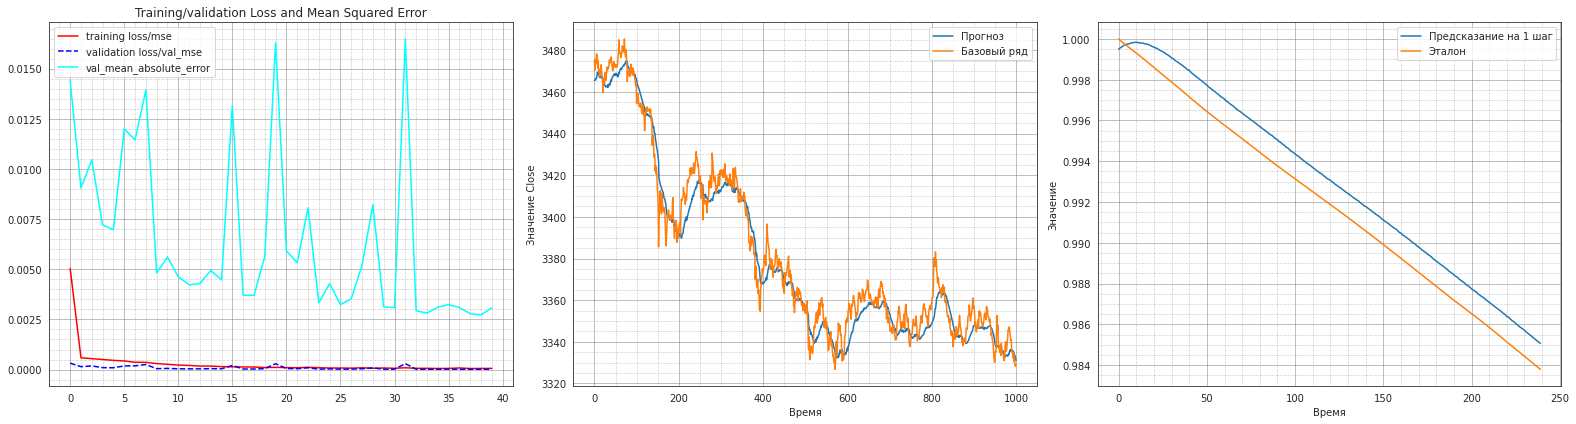

In [ ]:
modelD = Sequential()
print(f'Train shape: {th.trainDataGen[0][0].shape[1]}, {th.trainDataGen[0][0].shape[2]}')
modelD.add(Input(shape = (th.xLen, th.trainDataGen[0][0].shape[2])))
modelD.add(Dense(390, activation="elu" ))
modelD.add(Dense(360, activation="elu" ))
modelD.add(Dropout(rate=0.05))
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

th.compile_model(modelD, 'best_model')

th.model_test(modelD, 
              'best_model_dense_2', 
              EPOCHS=40, 
              start_patience=15, 
              LR=1e-05)

th.load_model_weigths(f'{th.directory}/best_model_dense_2.h5')
th.figureShow()

#### Используем новый датагенератор

In [ ]:
class TSDataGenerator(TimeseriesGenerator):
  def __init__(self, data, targets, length,
                sampling_rate=1,
                stride=1,
                start_index=0,
                overlap = 0,
                end_index=None,
                shuffle=False,
                reverse=False,
                batch_size=128,
                ):

      if len(data) != len(targets):
          raise ValueError('Data and targets have to be' +
                            ' of same length. '
                            'Data length is {}'.format(len(data)) +
                            ' while target length is {}'.format(len(targets)))
      if overlap >= length:
          raise ValueError(f'`overlap={overlap} >= length={length}` is disallowed')
      if overlap > 0: start_index += overlap

      self.data = data
      self.targets = targets
      self.length = length
      self.sampling_rate = sampling_rate
      self.stride = stride
      self.start_index = start_index + length
      self.overlap = overlap
      if end_index is None:
          end_index = len(data) - 1
      self.end_index = end_index
      self.shuffle = shuffle
      self.reverse = reverse
      self.batch_size = batch_size

      if self.start_index > self.end_index:
          raise ValueError('`start_index+length=%i > end_index=%i` '
                            'is disallowed, as no part of the sequence '
                            'would be left to be used as current step.'
                            % (self.start_index, self.end_index))

      pass

# >>> n = 3  # group size
# >>> m = 1  # overlap size
# >>> [list_[i:i+n] for i in range(0, len(list_), n-m)]


  def __getitem__(self, index):
      if self.shuffle:
          rows = np.random.randint(
              self.start_index, self.end_index + 1, size=self.batch_size)
      else:
          i = (self.start_index + self.batch_size * self.stride * index) 
          rows = np.arange(i, min(i + self.batch_size *
                                  self.stride, self.end_index + 1), self.stride)

      samples = np.array([self.data[row - self.overlap - self.length :row :self.sampling_rate]
                          for row in rows])
      targets = np.array([self.targets[row] for row in rows])
      # print(samples.shape)
      if self.reverse:
          return samples[:, ::-1, ...], targets

      return samples, targets



class T5(TechnoBuild):
  def __init__(self, data, directory, project_name, xLen, valLen, trials, stride=1, batch_size=128, overlap=0, speedup_data=False):
    self.overlap = overlap
    super().__init__(data, directory, project_name, xLen, valLen, trials, stride, batch_size, speedup_data)
    pass


  def traingen(self, BATCH_SIZE=128):
    self.trainDataGen = TSDataGenerator(self.xTrain, self.yTrain,           #В качестве параметров наши выборки
                                                length=self.xLen,
                                                overlap=self.overlap, 
                                                stride=self.stride,         #Для каждой точки (из промежутка длины self.xLen)
                                                batch_size=BATCH_SIZE)       #Размер batch, который будем скармливать модели
    pass

  def testgen(self, BATCH_SIZE=128):
    self.testDataGen = TSDataGenerator(self.xTest, self.yTest,
                                           length=self.xLen,
                                           overlap = self.overlap,  
                                           stride=self.stride,
                                           batch_size=BATCH_SIZE)
    pass
  
  # def tsgenerator(self, BATCH_SIZE=128):
  #   self.traingen(BATCH_SIZE)
  #   self.testgen(BATCH_SIZE)
  #   self.dataset_ready = True
  #   print("Checking batch length", len(self.trainDataGen[0][0]))
  #   print("Checking batch shape", self.trainDataGen[0][0].shape)
  #   pass

  def build_model(self, hp):
    if not self.dataset_ready:
        self.createdataset ()
    model = Sequential()
    model.add(Input(shape = (self.xLen, self.trainDataGen[0][0].shape[2])))
    model.add(Dense(units=hp.Int(f'dense_1_units', 
                              min_value=340,   
                              max_value=440,   
                              default=390,
                              step=10),
                    activation='elu',
                    name = f'dense_layer1')
              )

    model.add(Dense(units=hp.Int(f'dense_2_units', 
                      min_value=330,   
                      max_value=400,   
                      default=390,
                      step=10),
            activation='elu',
            name = f'dense_layer2')
      )
    model.add(Flatten()) 
    model.add(Dense(1, activation='linear'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='mse',
                  metrics='mse',
                  )
    return model

In [ ]:
experiments_data_path = os.path.join(DEV, "sunday_data/experiments")

th = T5(data_df, 
        os.path.join(experiments_data_path), 
        "Dense_3", 
        xLen=30, 
        valLen=43200, 
        trials=15, 
        stride=1, 
        batch_size=240, 
        speedup_data=True)

th.EXECUTIONS_PER_TRIAL = 2
th.EPOCHS = 20
th.main(search_type='HYPERBAND')
th.tuner.search_space_summary()

x_train: (219600, 5), x_test (43168, 5)
Checking xTrain_generated length 219570
Checking xTrain_generated shape (219570, 30, 5)
Checking xTest_generated length 43138
Checking xTest_generated shape (43138, 30, 5)
Checking yTrain_generated length 219570
Checking yTrain_generated shape (219570,)
Checking yTest_generated length 43138
Checking yTest_generated shape (43138,)
Checking generators batch length 240
Checking generators batch shape (240, 30, 5)
INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Python/sunday_data/experiments/Dense_3/oracle.json
Search space summary
Default search space size: 3
dense_1_units (Int)
{'default': 390, 'conditions': [], 'min_value': 340, 'max_value': 440, 'step': 10, 'sampling': None}
dense_2_units (Int)
{'default': 390, 'conditions': [], 'min_value': 330, 'max_value': 400, 'step': 10, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}


In [ ]:
th.search()

Trial 30 Complete [00h 02m 36s]
val_mse: 3.0177382086549187e-06

Best val_mse So Far: 2.8269215590626118e-06
Total elapsed time: 00h 30m 50s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = th.aftersearchtest()
model.evaluate(th.testDataGen)
th.tuner.results_summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_layer1 (Dense)         (None, 30, 440)           2640      
_________________________________________________________________
dense_layer2 (Dense)         (None, 30, 330)           145530    
_________________________________________________________________
flatten (Flatten)            (None, 9900)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 9901      
Total params: 158,071
Trainable params: 158,071
Non-trainable params: 0
_________________________________________________________________
180/180 [==============================] - 1s 3ms/step - loss: 2.6500e-06 - mse: 2.6500e-06
{'dense_1_units': 440, 'dense_2_units': 330, 'learning_rate': 0.0001, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}

1

## После выбора модели изменим размер окна xLen, выборки датасета и оптимизируем только кол-во нейронов в модели 

In [ ]:
class T1D(T5):
    def build_model(self, hp):
        if not self.dataset_ready:
            self.createdataset ()
        model = Sequential()
        model.add(Input(shape = (self.xLen, self.trainDataGen[0][0].shape[2])))
        model.add(Dense(units=hp.Int(f'dense_1_units', 
                                  min_value=340,   
                                  max_value=440,   
                                  default=390,
                                  step=10),
                        activation='elu',
                        name = f'dense_layer1')
                  )

        model.add(Dense(units=hp.Int(f'dense_2_units', 
                          min_value=330,   
                          max_value=400,   
                          default=390,
                          step=10),
                activation='elu',
                name = f'dense_layer2')
          )
        model.add(Flatten()) 
        model.add(Dense(1, activation='linear'))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Fixed('learning_rate', value=1e-5)
        model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                      loss='mse',
                      metrics='mse',
                     )
        return model

In [ ]:
experiments_data_path = os.path.join(DEV, "sunday_data/experiments")

th = T1D(data_df, 
        os.path.join(experiments_data_path), 
        "Dense_4", 
        xLen=30, 
        valLen=43200, 
        trials=15, 
        stride=1, 
        batch_size=240, 
        speedup_data=True)

th.EXECUTIONS_PER_TRIAL = 2
th.EPOCHS = 25
th.main(search_type='BAYESIAN')
th.tuner.search_space_summary()

x_train: (219600, 5), x_test (43168, 5)
Checking xTrain_generated length 219570
Checking xTrain_generated shape (219570, 30, 5)
Checking xTest_generated length 43138
Checking xTest_generated shape (43138, 30, 5)
Checking yTrain_generated length 219570
Checking yTrain_generated shape (219570,)
Checking yTest_generated length 43138
Checking yTest_generated shape (43138,)
Checking generators batch length 240
Checking generators batch shape (240, 30, 5)
Search space summary
Default search space size: 3
dense_1_units (Int)
{'default': 390, 'conditions': [], 'min_value': 340, 'max_value': 440, 'step': 10, 'sampling': None}
dense_2_units (Int)
{'default': 390, 'conditions': [], 'min_value': 330, 'max_value': 400, 'step': 10, 'sampling': None}
learning_rate (Fixed)
{'conditions': [], 'value': 1e-05}


In [ ]:
th.search()

Search space summary
Default search space size: 3
dense_1_units (Int)
{'default': 390, 'conditions': [], 'min_value': 340, 'max_value': 440, 'step': 10, 'sampling': None}
dense_2_units (Int)
{'default': 390, 'conditions': [], 'min_value': 330, 'max_value': 400, 'step': 10, 'sampling': None}
learning_rate (Fixed)
{'conditions': [], 'value': 1e-05}

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
dense_1_units     |390               |?                 
dense_2_units     |400               |?                 
learning_rate     |1e-05             |?                 

Epoch 1/25
915/915 [==============================] - 5s 5ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 2.4165e-04 - val_mse: 2.4165e-04
Epoch 2/25
805/915 [=========================>....] - ETA: 0s - loss: 5.6123e-05 - mse: 5.6123e-05

In [ ]:
model = th.aftersearchtest()
model.evaluate(th.testDataGen)
th.tuner.results_summary()

In [ ]:
modelD = Sequential()
print(f'Train shape: {th.trainDataGen[0][0].shape[1]}, {th.trainDataGen[0][0].shape[2]}')
modelD.add(Input(shape = (th.xLen, th.trainDataGen[0][0].shape[2])))
modelD.add(Dense(430, activation="elu" ))
modelD.add(Dense(390, activation="elu" ))
modelD.add(Dropout(rate=0.05))
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

th.compile_model(modelD, 'best_model')
th.model_test(modelD, 'best_model_dense_4', EPOCHS=40, start_patience=15, LR=1e-05)

In [ ]:
th.compile_model(modelD, 'best_model')
th.load_model_weigths(f'{th.directory}/best_model_dense_4.h5')
th.figureShow()

# PRO. Вариант 2. Base model
Сделайте несколько усовершенствований в предсказании временного ряда
* Добавьте к исходному сигналу расширенные данные:
  - попарные разности каналов
  - модули попарных разностей каналов
  - попарные произведения каналов
  - обратное значение каналов x_new = 1/(x + 1e-3)
  - первые производные каналов (x[n] - x[n-1])
  - вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])
* Сделайте бОльший “просмотр сети в прошлое”, при формировании входного сигнала используйте:
  - 100 точек с шагом назад по 1
  - 100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек)


In [ ]:
class T5_LSTM(TechnoBuild):
  def build_model(self, hp):
    if not self.dataset_ready:
        self.createdataset()
    activation1 = hp.Choice('activation1',
                            [
                              'linear',
                              'softmax',
                              'softplus',
                              'softsign',
                              'relu',
                              'tanh',
                              'sigmoid',
                              'hard_sigmoid',
                            ], 
                            default = "linear"
                            )
    activation2 = hp.Choice('activation2',
                            [
                              'linear',
                              'softmax',
                              'softplus',
                              'softsign',
                              'relu',
                              'tanh',
                              'sigmoid',
                              'hard_sigmoid',
                            ], 
                            default = "linear"
                            )
    activation3 = hp.Choice('activation3',
                            [
                              'linear',
                              'softmax',
                              'softplus',
                              'softsign',
                              'relu',
                              'tanh',
                              'sigmoid',
                              'hard_sigmoid',
                            ], 
                            default = "linear"
                            )
    dataInput = Input(shape=(th.trainDataGen[0][0].shape[1], th.trainDataGen[0][0].shape[2]))
    lstm_units = hp.Int(f'lstm_filters', 10, 400, step=5, default=20)
    conv_filters = hp.Int(f'conv_filters', 10, 400, step=5, default=20)
    # conv_kernel_size = hp.Choice(f'conv_kernel_size', values=[1, 2, 3, 4, 5], default=th.trainDataGen[0][0].shape[2]) 

    lstmWay = LSTM(lstm_units, return_sequences="True")(dataInput)
    convWay = Conv1D(conv_filters, kernel_size=th.trainDataGen[0][0].shape[2], activation=hp.get('activation1'))(dataInput)

    lstmConvWay = Conv1D(conv_filters,  kernel_size=th.trainDataGen[0][0].shape[2], activation=hp.get('activation2'))(lstmWay)
    convLstmWay = LSTM(lstm_units, return_sequences ="True")(convWay)

    lstmWay = LSTM(lstm_units, return_sequences="True")(lstmWay)
    convWay = Conv1D(conv_filters, kernel_size=th.trainDataGen[0][0].shape[2], activation=hp.get('activation3'))(convWay)

    lstmWay = Flatten()(lstmWay)
    convWay = Flatten()(convWay)
    lstmConvWay = Flatten()(lstmConvWay)
    convLstmWay = Flatten()(convLstmWay)

    finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
    finWay = Dense(hp.Int(f'dense_filters', 10, 400, step=5, default=10), activation="linear")(finWay)
    finWay = Dense(th.yTrain.shape[1], activation="linear")(finWay)
    
    modelX = Model(dataInput, finWay)

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    modelX.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='mse',
                  metrics='mse',
                  )
    return modelX

In [ ]:
experiments_data_path = os.path.join(DEV, "sunday_data/experiments")

th = T5_LSTM(data_df, 
        os.path.join(experiments_data_path), 
        "T5_LSTM", 
        xLen=30, 
        valLen=43200, 
        trials=20, 
        stride=1, 
        batch_size=240, 
        speedup_data=True)

th.EXECUTIONS_PER_TRIAL = 2
th.EPOCHS = 25
th.main(search_type='HYPERBAND')
th.tuner.search_space_summary()

x_train: (219600, 5), x_test (43168, 5)
Checking xTrain_generated length 219570
Checking xTrain_generated shape (219570, 30, 5)
Checking xTest_generated length 43138
Checking xTest_generated shape (43138, 30, 5)
Checking yTrain_generated length 219570
Checking yTrain_generated shape (219570,)
Checking yTest_generated length 43138
Checking yTest_generated shape (43138,)
Checking generators batch length 240
Checking generators batch shape (240, 30, 5)
Search space summary
Default search space size: 7
activation1 (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid'], 'ordered': False}
activation2 (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid'], 'ordered': False}
activation3 (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigm

In [ ]:
th.search()

Trial 30 Complete [00h 26m 11s]
val_mse: 1.3935959032096434e-05

Best val_mse So Far: 5.457150109577924e-06
Total elapsed time: 04h 02m 17s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = th.aftersearchtest()
model.evaluate(th.testDataGen)
th.tuner.results_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 30, 90)       34560       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 26, 195)      5070        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 30, 90)       65160       lstm[0][0]                       
______________________________________________________________________________________________

In [ ]:
dataInput = Input(shape=(th.trainDataGen[0][0].shape[1], th.trainDataGen[0][0].shape[2]))

lstmWay = LSTM(20, return_sequences="True")(dataInput)
convWay = Conv1D(20, 5, activation="relu")(dataInput)

lstmConvWay = Conv1D(20, 5, activation="relu")(lstmWay)
convLstmWay = LSTM(20, return_sequences="True")(convWay)

lstmWay = LSTM(20, return_sequences="True")(lstmWay)
convWay = Conv1D(20, 5, activation="relu")(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(th.yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)
th.compile_model(modelX, 'best_model')

In [ ]:
th.model_test(modelX, 'best_model_base_X', EPOCHS=10, start_patience=15, LR=1e-05)
th.load_model_weigths(f'{th.directory}/best_model_base_X.h5')
th.figureShow()

## Используем Keras Tuner для нахождения лучшего варианта модели

In [ ]:
experiments_data_path = os.path.join(DEV, "sunday_data/experiments")
th = T5_LSTM(data_df, experiments_data_path, 'LSTM_DX_1', xLen=30, valLen=43200, trials=25, stride=1, batch_size=360)

# th = T5_LSTM(data_df, '/content/drive/My Drive/Colab Notebooks/data/dz20/testing/pro', 'LSTM_DX_1', xLen=30, valLen=43200, trials=25, stride=1, batch_size=360)
th.EXECUTIONS_PER_TRIAL = 2
th.EPOCHS = 40
th.main(search_type='HYPERBAND')
th.tuner.search_space_summary()

x_train: (219600, 5), x_test (43168, 5)
Checking batch length 360
Checking batch shape (360, 30, 5)
INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Python/sunday_data/experiments/LSTM_DX_1/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Python/sunday_data/experiments/LSTM_DX_1/tuner0.json
Search space summary
Default search space size: 7
activation1 (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid'], 'ordered': False}
activation2 (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid'], 'ordered': False}
activation3 (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid'], 'ordered': False}
lstm_filters (Int)
{'default': 20, 'conditions': [], 'min_value': 10,

In [ ]:
th.search()

Trial 6 Complete [00h 05m 38s]
val_mse: 3.79015073121991e-05

Best val_mse So Far: 1.7229387594852597e-05
Total elapsed time: 01h 05m 10s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model = th.aftersearchtest()
model.evaluate(th.testDataGen)
th.tuner.results_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 30, 295)      355180      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 26, 275)      7150        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 30, 295)      697380      lstm[0][0]                       
______________________________________________________________________________________________

## Протестируем выбранную модель  #1

In [ ]:
if not th.dataset_ready:
  th.createdataset()

print (f'Train shape: ({th.trainDataGen[0][0].shape[1]}, {th.trainDataGen[0][0].shape[2]})')
dataInput = Input(shape=(th.trainDataGen[0][0].shape[1], th.trainDataGen[0][0].shape[2]))

lstmWay = LSTM(295, return_sequences="True")(dataInput)
convWay = Conv1D(275, kernel_size=5, activation='linear')(dataInput)

lstmConvWay = Conv1D(275,  kernel_size=5, activation='softmax')(lstmWay)
convLstmWay = LSTM(295, return_sequences ="True")(convWay)

lstmWay = LSTM(295, return_sequences="True")(lstmWay)
convWay = Conv1D(275, kernel_size=5, activation='softsign')(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(55, activation="linear")(finWay)
finWay = Dense(th.yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)
modelX.compile(
              optimizer=Adam(learning_rate=1e-5),
              loss='mse',
              metrics=['mse'],
              )
th.compile_model(modelX, 'best_model_base_DX_4_1')

Train shape: (30, 5)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 30, 295)      355180      input_3[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 26, 275)      7150        input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 30, 295)      697380      lstm[0][0]                       
_________________________________________________________________________

In [ ]:
th.stride = 1
th.xLen=30
th.valLen=43200
th.model_test(modelX, 'best_model_base_DX_4_1', EPOCHS=20, start_patience=10, LR=1e-05)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 30, 295)      355180      input_3[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 26, 275)      7150        input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 30, 295)      697380      lstm[0][0]                       
______________________________________________________________________________________________

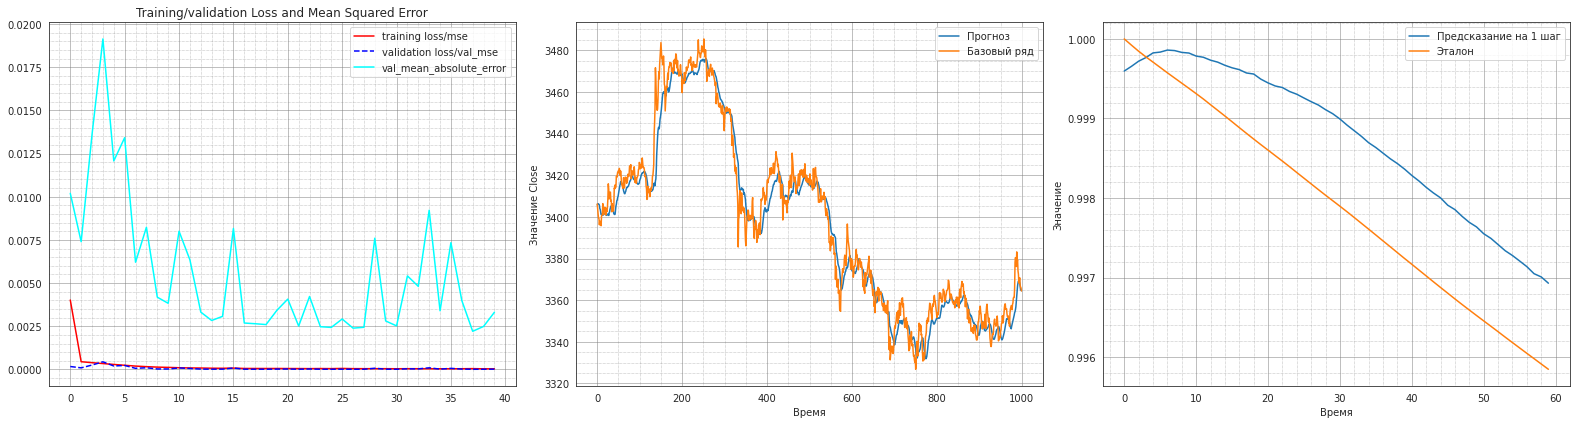

In [ ]:
th.compile_model(modelX, 'best_model_base_DX_4_1')
th.load_model_weigths(f'{th.directory}/best_model_base_DX_4_1.h5')
th.figureShow()

## Протестируем выбранную модель  #2

In [ ]:
if not th.dataset_ready:
  th.createdataset()

print (f'Train shape: ({th.trainDataGen[0][0].shape[1]}, {th.trainDataGen[0][0].shape[2]})')
dataInput = Input(shape=(th.trainDataGen[0][0].shape[1], th.trainDataGen[0][0].shape[2]))

lstmWay = LSTM(65, return_sequences="True")(dataInput)
convWay = Conv1D(35, kernel_size=5, activation='linear')(dataInput)

lstmConvWay = Conv1D(35,  kernel_size=5, activation='sigmoid')(lstmWay)
convLstmWay = LSTM(65, return_sequences ="True")(convWay)

lstmWay = LSTM(65, return_sequences="True")(lstmWay)
convWay = Conv1D(35, kernel_size=5, activation='linear')(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(55, activation="linear")(finWay)
finWay = Dense(th.yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)
modelX.compile(
              optimizer=Adam(learning_rate=1e-6),
              loss='mse',
              metrics=['mse'],
              )

Train shape: (30, 5)


In [ ]:
th.stride = 1
th.xLen=30
th.valLen=43200
th.model_test(modelX, 'best_model_base_DX_4_2', EPOCHS=20, start_patience=10, LR=1e-05)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 30, 65)       18460       input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 26, 35)       910         input_5[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 30, 65)       34060       lstm_6[0][0]                     
____________________________________________________________________________________________

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 30, 65)       18460       input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 26, 35)       910         input_5[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 30, 65)       34060       lstm_6[0][0]                     
____________________________________________________________________________________________

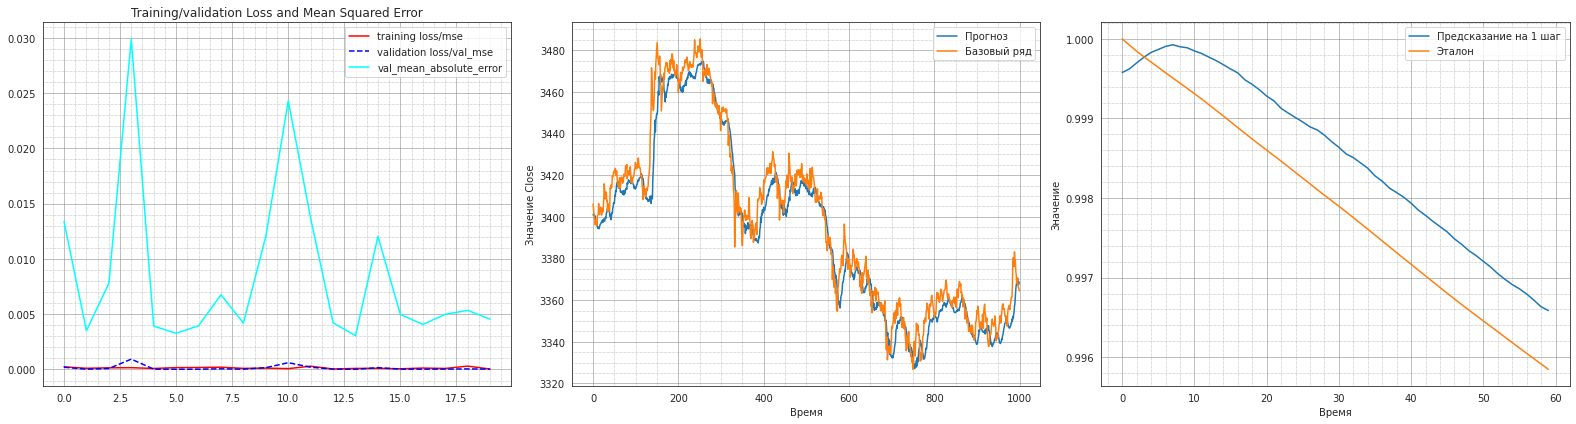

In [ ]:
th.compile_model(modelX, 'best_model_base_DX_4_2')
th.load_model_weigths(f'{th.directory}/best_model_base_DX_4_2.h5')
th.figureShow()

### Тест одномерной свертки с разными kernels и concatenate


In [ ]:
class T5_conv1d_x4(TechnoBuild):
  def build_model(self, hp):
    if not self.dataset_ready:
        self.createdataset()

    conv_filters = hp.Int(f'conv_filters', 8, 128, step=8, default=16)

    activation1 = hp.Choice('activation1',
                            ['linear',
                             'softmax',
                             'softplus',
                             'softsign',
                             'relu',
                             'tanh',
                             'sigmoid',
                             'hard_sigmoid'], 
                            default="linear")
    activation2 = hp.Choice('activation2',
                            ['linear',
                             'softmax',
                             'softplus',
                             'softsign',
                             'relu',
                             'tanh',
                             'sigmoid',
                             'hard_sigmoid'], 
                            default="linear")
    activation3 = hp.Choice('activation3',
                            ['linear',
                             'softmax',
                             'softplus',
                             'softsign',
                             'relu',
                             'tanh',
                             'sigmoid',
                             'hard_sigmoid'], 
                            default="linear")
    activation3 = hp.Choice('activation4',
                            ['linear',
                             'softmax',
                             'softplus',
                             'softsign',
                             'relu',
                             'tanh',
                             'sigmoid',
                             'hard_sigmoid'], 
                            default="linear")



    inputs = Input(shape=(th.trainDataGen[0][0].shape[1], th.trainDataGen[0][0].shape[2]))

    x = Conv1D(conv_filters,3,padding='same')(inputs) # сверточнй слой
    x1 = Activation(hp.get('activation1'))(x) # активация

    x = Conv1D(conv_filters*2,5,padding='same')(x1) # сверточнй слой
    x2 = Activation(hp.get('activation2'))(x) # активация

    x = Conv1D(conv_filters*4,15,padding='same')(x2) # сверточнй слой
    x3 = Activation(hp.get('activation3'))(x) # активация

    x = Conv1D(conv_filters*8,30,padding='same')(x3) # сверточнй слой
    x4 = Activation(hp.get('activation4'))(x) # активация

    fin = concatenate([inputs,x1,x2,x3,x4]) # складываем выходы слоев
    fin = Conv1D(conv_filters*8,2,padding='same')(fin) # сверточнй слой
    fin = Flatten()(fin) # преобразуем в одномерный вектор
    fin = Dense(1)(fin) # полносвязанный слой
    #создаем модель
    modelC = Model(inputs, fin)
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    modelC.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='mse',
                  metrics='mse',
                  )
    
    
    return modelC

In [ ]:
experiments_data_path = os.path.join(DEV, "sunday_data/experiments")
th = T5_conv1d_x4(data_df, experiments_data_path, 'T5_conv1d_x4', xLen=120, valLen=43200, trials=25, stride=1, batch_size=360)
th.EXECUTIONS_PER_TRIAL = 2
th.EPOCHS = 20
th.main(search_type='HYPERBAND')
th.tuner.search_space_summary()

x_train: (219600, 5), x_test (43078, 5)
Checking batch length 360
Checking batch shape (360, 120, 5)
INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Python/sunday_data/experiments/T5_conv1d_x4/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Python/sunday_data/experiments/T5_conv1d_x4/tuner0.json
Search space summary
Default search space size: 6
activation1 (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid'], 'ordered': False}
activation2 (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid'], 'ordered': False}
activation3 (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid'], 'ordered': False}
activation4 (Choice)
{'default': 'linear', 'conditions': [], '

In [ ]:
th.search()

In [ ]:
inputs = Input(shape=(th.trainDataGen[0][0].shape[1], th.trainDataGen[0][0].shape[2]))
x = Conv1D(128,3,padding='same')(inputs) # сверточнй слой
x1 = Activation('linear')(x) # активация

x = Conv1D(256,5,padding='same')(x1) # сверточнй слой
x2 = Activation('linear')(x) # активация

x = Conv1D(512,7,padding='same')(x2) # сверточнй слой
x3 = Activation('linear')(x) # активация

x = Conv1D(1024,12,padding='same')(x3) # сверточнй слой
x4 = Activation('linear')(x) # активация

fin = concatenate([inputs,x1,x2,x3,x4]) # складываем выходы слоев
fin = Conv1D(1024,2,padding='same')(fin) # сверточнй слой
fin = Flatten()(fin) # преобразуем в одномерный вектор
fin = Dense(1)(fin) # полносвязанный слой
#создаем модель
modelC = Model(inputs, fin)
#компилируем
modelC.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse')

In [ ]:
th.stride = 1
th.xLen=120
th.valLen=43200
th.model_test(modelC, 'best_model_base_T5_conv1d_x4', EPOCHS=20, start_patience=10, LR=1e-05)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 120, 128)     2048        input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 120, 128)     0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 120, 256)     164096      activation_4[0][0]               
____________________________________________________________________________________________

AttributeError: ignored

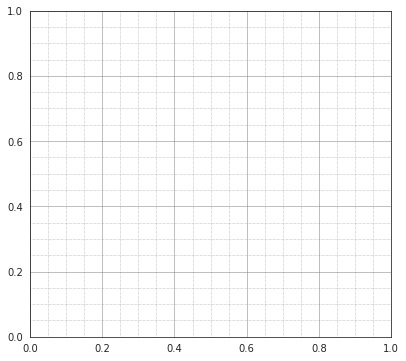

In [ ]:
th.compile_model(modelC, 'best_model_base_T5_conv1d_x4')
th.load_model_weigths(f'{th.directory}/best_model_base_T5_conv1d_x4.h5')
th.figureShow()

## Обработаем данные, для увеличения размера и информации в базе 
* Добавьте к исходному сигналу расширенные данные:
  - попарные разности каналов
  - модули попарных разностей каналов
  - попарные произведения каналов
  - обратное значение каналов x_new = 1/(x + 1e-3)
  - первые производные каналов (x[n] - x[n-1])
  - вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

In [ ]:
from itertools import combinations
from scipy.ndimage.filters import laplace
import operator
from random import sample

def abs_sub(a, b):
  return abs(a-b)

def back_funct(x):
  return 1/(x + 1e-3)

data_df = df.copy()
data_df.rename(columns = {'OPEN': 'OP',
                          'MAX': 'MX',
                          'MIN': 'MN',
                          'CLOSE': 'CL',
                          'VOLUME': 'VL'
                          }, inplace=True)
all_cols = data_df.columns.to_list()
comb_gen = combinations(all_cols, 2)
comb_lst = [comb for comb in comb_gen]

paired_oper_dict = {'sub_': operator.sub, 
                    'abs_sub_': abs_sub, 
                    'mul_': operator.mul}
single_oper_dict = {'bck_': back_funct,
                    'dx_': np.gradient,
                    'dx2_': laplace}

for i, (key, funct) in enumerate(paired_oper_dict.items()):
  for comb in comb_lst:
    # col_name = f'{comb[0]}{key}{comb[1]}'
    data_df[f'{key}{comb[0]}{comb[1]}'] = funct(data_df[f'{comb[0]}'], data_df[f'{comb[1]}'])
    # data_df[col_name] = 1

sec_cols = []
for i in range(3):
  sec_cols.append(all_cols)

'''
На случай если надо работать с парами колонок
'''
# sec_cols.append(data_df.columns.to_list()[5:15])
# sec_cols.append(data_df.columns.to_list()[5:15])
for cols, (key, funct) in zip(sec_cols, single_oper_dict.items()):
  for col in cols:
     data_df[f'{key}{col}'] = funct(data_df[f'{col}'].values)
data_df

,OP,MX,MN,CL,VL,sub_OPMX,sub_OPMN,sub_OPCL,sub_OPVL,sub_MXMN,sub_MXCL,sub_MXVL,sub_MNCL,sub_MNVL,sub_CLVL,abs_sub_OPMX,abs_sub_OPMN,abs_sub_OPCL,abs_sub_OPVL,abs_sub_MXMN,abs_sub_MXCL,abs_sub_MXVL,abs_sub_MNCL,abs_sub_MNVL,abs_sub_CLVL,mul_OPMX,mul_OPMN,mul_OPCL,mul_OPVL,mul_MXMN,mul_MXCL,mul_MXVL,mul_MNCL,mul_MNVL,mul_CLVL,bck_OP,bck_MX,bck_MN,bck_CL,bck_VL,dx_OP,dx_MX,dx_MN,dx_CL,dx_VL,dx2_OP,dx2_MX,dx2_MN,dx2_CL,dx2_VL
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,1.0,1.0,-196.0,5.8,5.8,-191.2,0.0,-197.0,-197.0,4.8,1.0,1.0,196.0,5.8,5.8,191.2,0.0,197.0,197.0,5538485.80,5524850.00,5524850.00,5987997.0,5536130.00,5536130.00,6000222.6,5522500.00,5985450.0,5985450.0,0.000425,0.000424,0.000426,0.000426,0.000393,1.90,-0.10,0.00,5.70,-2352.0,1.9,-0.1,0.0,5.7,-2352
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.9,-2.8,2157.9,5.7,0.0,2160.7,-5.7,2155.0,2160.7,2.8,2.9,2.8,2157.9,5.7,0.0,2160.7,5.7,2155.0,2160.7,5542726.53,5529315.00,5542726.53,458815.5,5535895.00,5549322.49,459361.5,5535895.00,458250.0,459361.5,0.000425,0.000425,0.000426,0.000425,0.005128,2.30,0.10,0.70,2.05,-1145.0,0.8,0.4,1.4,-7.3,2414
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,4.2,1.5,2098.6,4.6,1.9,2099.0,-2.7,2094.4,2097.1,0.4,4.2,1.5,2098.6,4.6,1.9,2099.0,2.7,2094.4,2097.1,5549793.60,5538957.84,5545317.96,605389.2,5539898.40,5546259.60,605492.0,5535430.74,604309.8,605003.7,0.000425,0.000424,0.000425,0.000425,0.003891,0.80,-0.35,0.60,-1.00,284.0,-3.8,-1.3,-1.6,1.2,444
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,3.3,0.8,1591.5,3.8,1.3,1592.0,-2.5,1588.2,1590.7,0.5,3.3,0.8,1591.5,3.8,1.3,1592.0,2.5,1588.2,1590.7,5544847.50,5535900.40,5541786.65,1796483.5,5537076.00,5542963.50,1796865.0,5534019.44,1793965.6,1795873.1,0.000425,0.000425,0.000425,0.000425,0.001311,-1.25,-1.05,0.85,-0.25,-13.0,-0.3,-0.1,2.1,0.3,-1038
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.0,-0.5,2122.1,0.8,0.3,2122.9,-0.5,2122.1,2122.6,0.8,0.0,0.5,2122.1,0.8,0.3,2122.9,0.5,2122.1,2122.6,5538962.09,5537079.61,5538256.16,543566.1,5538962.09,5540139.04,543750.9,5538256.16,543566.1,543681.6,0.000425,0.000425,0.000425,0.000425,0.004329,-1.35,-1.60,-0.60,-1.85,85.5,0.1,-1.0,-5.0,-3.5,1235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217942,5183.5,5183.5,5183.5,5183.5,31523,0.0,0.0,0.0,-26339.5,0.0,0.0,-26339.5,0.0,-26339.5,-26339.5,0.0,0.0,0.0,26339.5,0.0,0.0,26339.5,0.0,26339.5,26339.5,26868672.25,26868672.25,26868672.25,163399470.5,26868672.25,26868672.25,163399470.5,26868672.25,163399470.5,163399470.5,0.000193,0.000193,0.000193,0.000193,0.000032,6.75,5.75,8.00,5.75,1370.5,-13.5,-11.5,-16.0,-11.5,-55607
217943,5183.5,5183.5,5183.5,5183.5,5090,0.0,0.0,0.0,93.5,0.0,0.0,93.5,0.0,93.5,93.5,0.0,0.0,0.0,93.5,0.0,0.0,93.5,0.0,93.5,93.5,26868672.25,26868672.25,26868672.25,26384015.0,26868672.25,26868672.25,26384015.0,26868672.25,26384015.0,26384015.0,0.000193,0.000193,0.000193,0.000193,0.000196,0.00,0.00,0.00,0.00,-15646.5,0.0,0.0,0.0,0.0,21573
217944,5183.5,5183.5,5183.5,5183.5,230,0.0,0.0,0.0,4953.5,0.0,0.0,4953.5,0.0,4953.5,4953.5,0.0,0.0,0.0,4953.5,0.0,0.0,4953.5,0.0,4953.5,4953.5,26868672.25,26868672.25,26868672.25,1192205.0,26868672.25,26868672.25,1192205.0,26868672.25,1192205.0,1192205.0,0.000193,0.000193,0.000193,0.000193,0.004348,0.00,0.00,0.00,0.00,-2542.5,0.0,0.0,0.0,0.0,4635
217945,5183.5,5183.5,5183.5,5183.5,5,0.0,0.0,0.0,5178.5,0.0,0.0,5178.5,0.0,5178.5,5178.5,0.0,0.0,0.0,5178.5,0.0,0.0,5178.5,0.0,5178.5,5178.5,26868672.25,26868672.25,26868672.25,25917.5,26868672.25,26868672.25,25917.5,26868672.25,25917.5,25917.5,0.000193,0.000193,0.000193,0.000193,0.199960,0.00,0.00,0.00,0.00,382.0,0.0,0.0,0.0,0.0,1214


## Попробуем найти наиболее подходящий набор данных для NN с помощью Keras  Tuner  

In [ ]:
class T4(TechnoBuild):

  def build_model(self, hp):
 
    def get_col_name(_lst, ind1, ind2):
      print(_lst)
      return hp.Choice(f'set_{ind1}_colname_{ind2}', values=_lst)
      
    col_num = self.trainDataGen[0][0].shape[2]
    if self.bigdata:
      selection = []
      flat_stack = []
      for elem in self.stack:
        flat_stack.extend(elem)
      temp = hp.Fixed(f'set_qty', 7)
      temp_cols = flat_stack.copy()
      i = 1 
      counter = 0
      while counter < temp:
         # print(temp_cols) 
        col_name = hp.Choice(f'colname_{counter}', values=temp_cols)
        selection.append(col_name)
        counter +=1

        # if col_name in selection:
        #   print('in', col_name)
        #   temp_cols.remove(col_name)
        #   continue
        # else:
        #   print('ad', col_name)
        #   selection.append(col_name)
        #   counter +=1
        #   temp_cols.remove(col_name) 


      # for i, set_cols in enumerate(self.stack):
      #   # print(set_cols)
      #   # temp = hp.Int(f'set_{i}_qty', 0, len(set_cols)-1, default=1)
      #   temp = hp.Fixed(f'set_{i}_qty', 1)
      #   temp_cols = set_cols.copy() 
      #   # col_name = str()
      #    # for j in range(hp.get(f'set_{i}_qty')):
      #   for j in range(temp):
      #     # print(temp_cols) 
      #     col_name = get_col_name(temp_cols, i, j)
      #     selection.append(col_name)
      #     

      print (f'Selected columns:\n{selection}')


      kernel_values = [*range(1, len(selection)+len(self.base_cols)+1)]
      len_kernel_values = len(kernel_values)
      # print(kernel_values, len_kernel_values)
      self.choose_cols_data(selection)
    else:
      kernel_values = [*range(1, len(self.base_cols)+1)]
      len_kernel_values = len(kernel_values)
      # print(kernel_values, len_kernel_values)
      self.choose_cols_data(self.base_cols)

    if not self.dataset_ready:
      self.createdataset()
    print (f'Train shape: ({self.trainDataGen[0][0].shape[1]}, {len_kernel_values})')
    dataInput = Input(shape=(self.trainDataGen[0][0].shape[1], len_kernel_values))
    # twin_filters = hp.Int(f'twin_filters', len_kernel_values, 400, step=len_kernel_values, default=13*len_kernel_values)
    twin_filters = hp.Fixed(f'twin_filters', 13*len_kernel_values)

    print(f'twin_filters {twin_filters}')

    # conv_kernel_size = hp.Choice(f'conv_kernel_size', values=kernel_values) 

    conv_kernel_size = len_kernel_values

    lstmWay = LSTM(twin_filters, return_sequences="True")(dataInput)
    convWay = Conv1D(twin_filters, kernel_size=conv_kernel_size, activation='linear')(dataInput)

    lstmConvWay = Conv1D(twin_filters,  kernel_size=conv_kernel_size, activation='sigmoid')(lstmWay)
    convLstmWay = LSTM(twin_filters, return_sequences ="True")(convWay)

    lstmWay = LSTM(twin_filters, return_sequences="True")(lstmWay)
    convWay = Conv1D(twin_filters, kernel_size=conv_kernel_size, activation='linear')(convWay)

    lstmWay = Flatten()(lstmWay)
    convWay = Flatten()(convWay)
    lstmConvWay = Flatten()(lstmConvWay)
    convLstmWay = Flatten()(convLstmWay)

    finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
    # finWay = Dense(hp.Int(f'dense_filters', len_kernel_values, len_kernel_values*25, step=len_kernel_values, default=len_kernel_values*11), activation="linear")(finWay)
    finWay = Dense(hp.Fixed(f'dense_filters', len_kernel_values*11), activation="linear")(finWay)
    finWay = Dense(self.yTrain.shape[1], activation="linear")(finWay)
    
    modelX = Model(dataInput, finWay)
    modelX.compile(
                  optimizer=Adam(lr=1e-6),
                  loss='mse',
                  metrics=['mse'],
                  )
    return modelX

In [ ]:
th = T4(data_df, '/content/drive/My Drive/Colab Notebooks/data/dz20/testing/pro', 'LSTM_DX_2', xLen=100, valLen=50000, trials=2)
# th.stack
th.main(search_type='HYPERBAND')
th.search()

(481872, 50)
x_train: (431872, 5), x_test (49898, 5)
INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/Colab Notebooks/data/dz20/testing/pro/LSTM_DX_2/oracle.json
Selected columns:
['sub_OPMX', 'sub_OPMX', 'sub_OPMX', 'sub_OPMX', 'sub_OPMX', 'sub_OPMX', 'sub_OPMX', 'sub_OPMX']
x_train: (431872, 13), x_test (49898, 13)
Train shape: (100, 13)
twin_filters 65
INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/Colab Notebooks/data/dz20/testing/pro/LSTM_DX_2/tuner0.json


Selected columns:
['abs_sub_MNCL', 'mul_MXVL', 'bck_MN', 'dx2_OP', 'sub_OPMN', 'bck_MN', 'dx_MX', 'sub_OPMX']
x_train: (431872, 13), x_test (49898, 13)
Train shape: (100, 13)
twin_filters 65
Epoch 1/50
3374/3374 [==============================] - 81s 24ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 1.5046e-04 - val_mse: 1.5046e-04
Epoch 2/50
3374/3374 [==============================] - 80s 24ms/step - loss: 1.1474e-04 - mse: 1.1474e-04 - val_loss: 7.7696e-05 - val_mse: 7.7696e-05
Epoch 3/50
3374/3374 [==============================] - 80s 24ms/step - loss: 9.1007e-05 - mse: 9.1007e-05 - val_loss: 6.5509e-05 - val_mse: 6.5509e-05
Epoch 4/50
3374/3374 [==============================] - 80s 24ms/step - loss: 1.0124e-04 - mse: 1.0124e-04 - val_loss: 5.2006e-05 - val_mse: 5.2006e-05
Epoch 5/50
3374/3374 [==============================] - 80s 24ms/step - loss: 7.8398e-05 - mse: 7.8398e-05 - val_loss: 4.5233e-05 - val_mse: 4.5233e-05
Epoch 6/50
3374/3374 [==============================] - 8

Selected columns:
['sub_MXVL', 'sub_MXCL', 'sub_MXCL', 'abs_sub_MXCL', 'sub_MXCL', 'dx2_OP', 'bck_MX', 'dx_MN']
x_train: (431872, 13), x_test (49898, 13)
Train shape: (100, 13)
twin_filters 65
Epoch 1/50
3374/3374 [==============================] - 79s 23ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 1.9557e-04 - val_mse: 1.9557e-04
Epoch 2/50
3374/3374 [==============================] - 78s 23ms/step - loss: 1.3268e-04 - mse: 1.3268e-04 - val_loss: 6.8730e-04 - val_mse: 6.8730e-04
Epoch 3/50
3374/3374 [==============================] - 78s 23ms/step - loss: 1.3727e-04 - mse: 1.3727e-04 - val_loss: 1.1487e-04 - val_mse: 1.1487e-04
Epoch 4/50
3374/3374 [==============================] - 79s 23ms/step - loss: 1.2451e-04 - mse: 1.2451e-04 - val_loss: 9.5636e-05 - val_mse: 9.5636e-05
Epoch 5/50
3374/3374 [==============================] - 77s 23ms/step - loss: 1.3770e-04 - mse: 1.3770e-04 - val_loss: 1.0051e-04 - val_mse: 1.0051e-04
Epoch 6/50
3374/3374 [==============================] -

Selected columns:
['mul_MNVL', 'sub_OPCL', 'abs_sub_MXMN', 'mul_OPCL', 'mul_MXCL', 'bck_MN', 'mul_MXVL', 'sub_MXMN']
x_train: (431872, 13), x_test (49898, 13)
Train shape: (100, 13)
twin_filters 65
Epoch 1/50
3374/3374 [==============================] - 81s 24ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 1.2407e-04 - val_mse: 1.2407e-04
Epoch 2/50
3374/3374 [==============================] - 81s 24ms/step - loss: 1.3689e-04 - mse: 1.3689e-04 - val_loss: 2.5624e-04 - val_mse: 2.5624e-04
Epoch 3/50
3374/3374 [==============================] - 80s 24ms/step - loss: 1.2887e-04 - mse: 1.2887e-04 - val_loss: 9.7792e-05 - val_mse: 9.7792e-05
Epoch 4/50
3374/3374 [==============================] - 80s 24ms/step - loss: 1.1515e-04 - mse: 1.1515e-04 - val_loss: 7.5357e-05 - val_mse: 7.5357e-05
Epoch 5/50
3374/3374 [==============================] - 80s 24ms/step - loss: 1.0575e-04 - mse: 1.0575e-04 - val_loss: 2.8565e-04 - val_mse: 2.8565e-04
Epoch 6/50
3374/3374 [============================

INFO:tensorflow:Oracle triggered exit


In [ ]:
model = th.aftersearchtest()
model.evaluate(th.testDataGen)
th.tuner.results_summary()

Selected columns:
['abs_sub_OPMN', 'abs_sub_MXMN', 'dx2_MN', 'dx2_MX', 'abs_sub_OPMN', 'sub_MNVL', 'dx2_OP', 'sub_CLVL']
x_train: (431872, 13), x_test (49898, 13)
Train shape: (100, 13)
twin_filters 65
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 13)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 100, 65)      20540       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 88, 65)       11050       input_1[0][0]                    
___________________________________________________________________________________

##Использование Keras Tuner для селекции данных. Выводы:
1. Несмотря на отсутствие специализированного решения ("в лоб"), Keras Tuner можно использовать для решения этой задачи. Специальный механизм наследования, позволит устанавливать родителей и потомков.
2. Длительность поиска, также можно уменьшить используя встроенный механизм Keras Tuner для распределенных вычислений (на разных colab/компьютерах с доступом к одной директории) 

## Добавим lookback - 100 точек,  к "окну" 150 точек выборки и добавим выбранные на предыдущем этапе колонки по ***score***

In [ ]:
class TSDataGenerator(TimeseriesGenerator):
  def __init__(self, data, targets, length,
                sampling_rate=1,
                stride=1,
                start_index=0,
                overlap = 0,
                end_index=None,
                shuffle=False,
                reverse=False,
                batch_size=128):

      if len(data) != len(targets):
          raise ValueError('Data and targets have to be' +
                            ' of same length. '
                            'Data length is {}'.format(len(data)) +
                            ' while target length is {}'.format(len(targets)))
      if overlap >= length:
          raise ValueError(f'`overlap={overlap} >= length={length}` is disallowed')
      if overlap > 0: start_index += overlap

      self.data = data
      self.targets = targets
      self.length = length
      self.sampling_rate = sampling_rate
      self.stride = stride
      self.start_index = start_index + length
      self.overlap = overlap
      if end_index is None:
          end_index = len(data) - 1
      self.end_index = end_index
      self.shuffle = shuffle
      self.reverse = reverse
      self.batch_size = batch_size

      if self.start_index > self.end_index:
          raise ValueError('`start_index+length=%i > end_index=%i` '
                            'is disallowed, as no part of the sequence '
                            'would be left to be used as current step.'
                            % (self.start_index, self.end_index))

      pass

# >>> n = 3  # group size
# >>> m = 1  # overlap size
# >>> [list_[i:i+n] for i in range(0, len(list_), n-m)]


  def __getitem__(self, index):
      if self.shuffle:
          rows = np.random.randint(
              self.start_index, self.end_index + 1, size=self.batch_size)
      else:
          i = (self.start_index + self.batch_size * self.stride * index) 
          rows = np.arange(i, min(i + self.batch_size *
                                  self.stride, self.end_index + 1), self.stride)

      samples = np.array([self.data[row - self.overlap - self.length :row :self.sampling_rate]
                          for row in rows])
      targets = np.array([self.targets[row] for row in rows])
      # print(samples.shape)
      if self.reverse:
          return samples[:, ::-1, ...], targets

      return samples, targets



class T5(TechnoBuild):
  def __init__(self, data, directory, project_name, xLen, valLen, trials ):
    self.overlap = 100
    self.stride = 1
    super().__init__(data, directory, project_name, xLen, valLen, trials)
    pass


  def traingen(self, BATCH_SIZE=128):
    self.trainDataGen = TSDataGenerator(self.xTrain, self.yTrain,           #В качестве параметров наши выборки
                                                length=self.xLen,
                                                overlap=self.overlap, 
                                                stride=self.stride, #Для каждой точки (из промежутка длины self.xLen)
                                                batch_size=BATCH_SIZE)                #Размер batch, который будем скармливать модели
    pass

  def testgen(self, BATCH_SIZE=128):
    self.testDataGen = TSDataGenerator(self.xTest, self.yTest,
                                           length=self.xLen,
                                           overlap = self.overlap,  
                                           stride=self.stride,
                                           batch_size=BATCH_SIZE)
    print(f'stride: {self.stride}')
    pass
  
  def tsgenerator(self, BATCH_SIZE=128):
    self.traingen(128)
    self.testgen(128)
    self.dataset_ready = True
    print(self.trainDataGen[0][1].shape) 
    pass
  
  def build_model(self, hp):
    if self.bigdata:
      selection = ['bck_OP', 'dx2_VL', 'mul_OPVL', 'sub_MNCL']
      self.dataset_ready = False
      print (f'Selected columns:\n{selection}')
      kernel_values = [*range(1, len(selection)+len(self.base_cols)+1)]
      len_kernel_values = len(kernel_values)
      # print(kernel_values, len_kernel_values)
      self.choose_cols_data(selection)
    else:
      kernel_values = [*range(1, len(self.base_cols)+1)]
      len_kernel_values = len(kernel_values)
      # print(kernel_values, len_kernel_values)
      self.choose_cols_data(self.base_cols)
    
    if not self.dataset_ready:
      self.createdataset()

    print (f'Train shape: ({self.trainDataGen[0][0].shape[1]}, {len_kernel_values})')
    dataInput = Input(shape=(self.trainDataGen[0][0].shape[1], len_kernel_values))
    # twin_filters = hp.Int(f'twin_filters', len_kernel_values, 400, step=len_kernel_values, default=13*len_kernel_values)
    twin_filters = hp.Fixed(f'twin_filters', 13*len_kernel_values)

    conv_kernel_size = len_kernel_values

    lstmWay = LSTM(twin_filters, return_sequences="True")(dataInput)
    convWay = Conv1D(twin_filters, kernel_size=conv_kernel_size, activation='linear')(dataInput)

    lstmConvWay = Conv1D(twin_filters,  kernel_size=conv_kernel_size, activation='sigmoid')(lstmWay)
    convLstmWay = LSTM(twin_filters, return_sequences ="True")(convWay)

    lstmWay = LSTM(twin_filters, return_sequences="True")(lstmWay)
    convWay = Conv1D(twin_filters, kernel_size=conv_kernel_size, activation='linear')(convWay)

    lstmWay = Flatten()(lstmWay)
    convWay = Flatten()(convWay)
    lstmConvWay = Flatten()(lstmConvWay)
    convLstmWay = Flatten()(convLstmWay)

    finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
    # finWay = Dense(hp.Int(f'dense_filters', len_kernel_values, len_kernel_values*25, step=len_kernel_values, default=len_kernel_values*11), activation="linear")(finWay)
    finWay = Dense(hp.Fixed(f'dense_filters', len_kernel_values*11), activation="linear")(finWay)
    finWay = Dense(self.yTrain.shape[1], activation="linear")(finWay)
    
    modelX = Model(dataInput, finWay)
    modelX.compile(
                  optimizer=Adam(lr=1e-6),
                  loss='mse',
                  metrics=['mse'],
                  )
    return modelX


In [ ]:
th = T5(data_df, '/content/drive/My Drive/Colab Notebooks/data/dz20/testing/pro', 'LSTM_DX_3', xLen=150, valLen=30000, trials=2)
# th.stack
th.main(search_type='HYPERBAND')
# th.search()

(481872, 50)
x_train: (451872, 5), x_test (29848, 5)
stride: 1
(128, 1)
INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/Colab Notebooks/data/dz20/testing/pro/LSTM_DX_3/oracle.json
Selected columns:
['bck_OP', 'dx2_VL', 'mul_OPVL', 'sub_MNCL']
x_train: (451872, 9), x_test (29848, 9)
stride: 1
(128, 1)
Train shape: (250, 9)
INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/Colab Notebooks/data/dz20/testing/pro/LSTM_DX_3/tuner0.json


### Сделаем тест lookback

Selected columns:
['dx2_MX', 'mul_OPMN', 'dx2_CL', 'dx2_VL', 'mul_MNVL', 'dx_MX', 'sub_OPCL', 'dx2_MN']
x_train: (451872, 13), x_test (29848, 13)
stride: 1
(128, 1)
Train shape: (250, 13)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 250, 13)]    0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 250, 169)     123708      input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 238, 65)      11050       input_2[0][0]                    
_________________________________________________________________________________________________

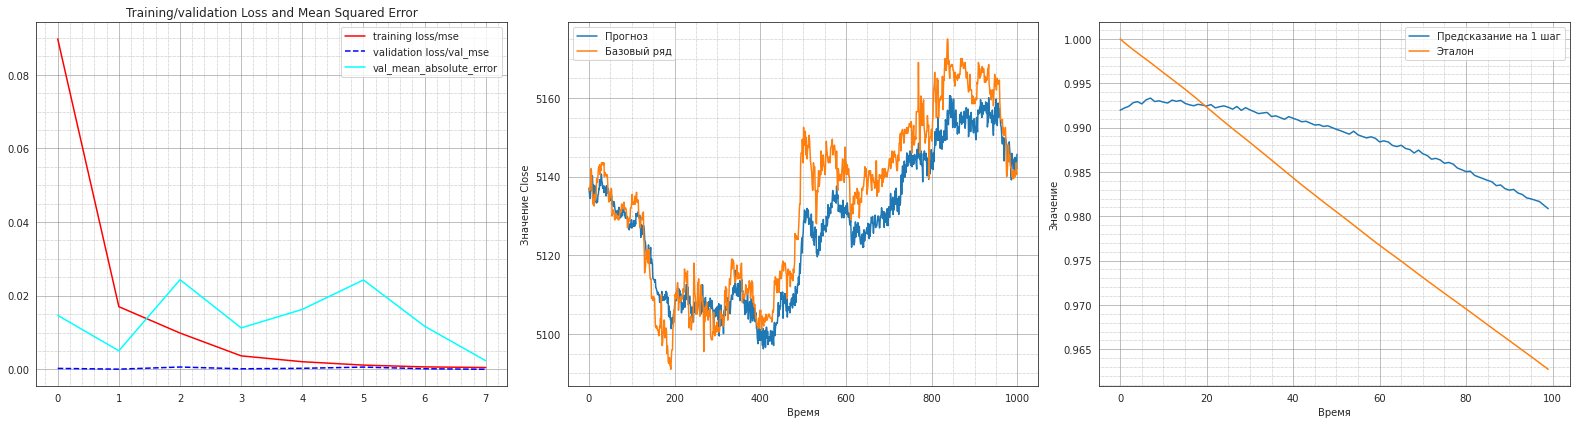

In [ ]:
if th.bigdata:
  # selection = ['bck_OP', 'dx2_VL', 'mul_OPVL', 'sub_MNCL']
  selection = ['dx2_MX', 'mul_OPMN', 'dx2_CL', 'dx2_VL', 'mul_MNVL', 'dx_MX', 'sub_OPCL', 'dx2_MN']
  # selection = ['dx_OP', 'mul_MXVL', 'bck_MN', 'abs_sub_CLVL', 'dx2_MX', 'mul_OPVL', 'sub_MNVL', 'bck_CL']
  th.dataset_ready = False
  print (f'Selected columns:\n{selection}')
  kernel_values = [*range(1, len(selection)+len(th.base_cols)+1)]
  len_kernel_values = len(kernel_values)
  # print(kernel_values, len_kernel_values)
  th.choose_cols_data(selection)
else:
  kernel_values = [*range(1, len(th.base_cols)+1)]
  len_kernel_values = len(kernel_values)
  # print(kernel_values, len_kernel_values)
  th.choose_cols_data(th.base_cols)

if not th.dataset_ready:
  th.createdataset()

print (f'Train shape: ({th.trainDataGen[0][0].shape[1]}, {len_kernel_values})')
dataInput = Input(shape=(th.trainDataGen[0][0].shape[1], len_kernel_values))
# twin_filters = hp.Int(f'twin_filters', len_kernel_values, 400, step=len_kernel_values, default=13*len_kernel_values)
twin_filters = 13*len_kernel_values
conv_kernel_size = len_kernel_values

lstmWay = LSTM(twin_filters, return_sequences="True")(dataInput)
convWay = Conv1D(65, kernel_size=conv_kernel_size, activation='linear')(dataInput)

lstmConvWay = Conv1D(65,  kernel_size=conv_kernel_size, activation='sigmoid')(lstmWay)
convLstmWay = LSTM(twin_filters, return_sequences ="True")(convWay)

lstmWay = LSTM(twin_filters, return_sequences="True")(lstmWay)
convWay = Conv1D(65, kernel_size=conv_kernel_size, activation='linear')(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
# finWay = Dense(hp.Int(f'dense_filters', len_kernel_values, len_kernel_values*25, step=len_kernel_values, default=len_kernel_values*11), activation="linear")(finWay)
finWay = Dense(len_kernel_values*11, activation="linear")(finWay)
finWay = Dense(th.yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)
modelX.compile(
              optimizer=Adam(lr=1e-6),
              loss='mse',
              metrics=['mse'],
              )
# th.compile_model(modelX, 'best_model_base_DX_5')
th.stride = 1
th.xLen=150
th.valLen=30000
th.model_test(modelX, 'best_model_base_DX_5', EPOCHS=8, start_patience=8, LR=1e-07)
th.load_model_weigths(f'{th.directory}/best_model_base_DX_5.h5')
# th.history = savehistory
th.figureShow()

## Сделаем шаг выборки = 10. При этом сохраним lookback 100 точек, и окно 300 точек. (фактически уменьшим выборку в 10 раз) 

Selected columns:
['dx2_MX', 'mul_OPMN', 'dx2_CL', 'dx2_VL', 'mul_MNVL', 'dx_MX', 'sub_OPCL', 'dx2_MN']
x_train: (451872, 13), x_test (29698, 13)
stride: 10
(128, 1)
Train shape: (400, 13)
Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 400, 13)]    0                                            
__________________________________________________________________________________________________
lstm_21 (LSTM)                  (None, 400, 169)     123708      input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 388, 65)      11050       input_8[0][0]                    
_______________________________________________________________________________________________

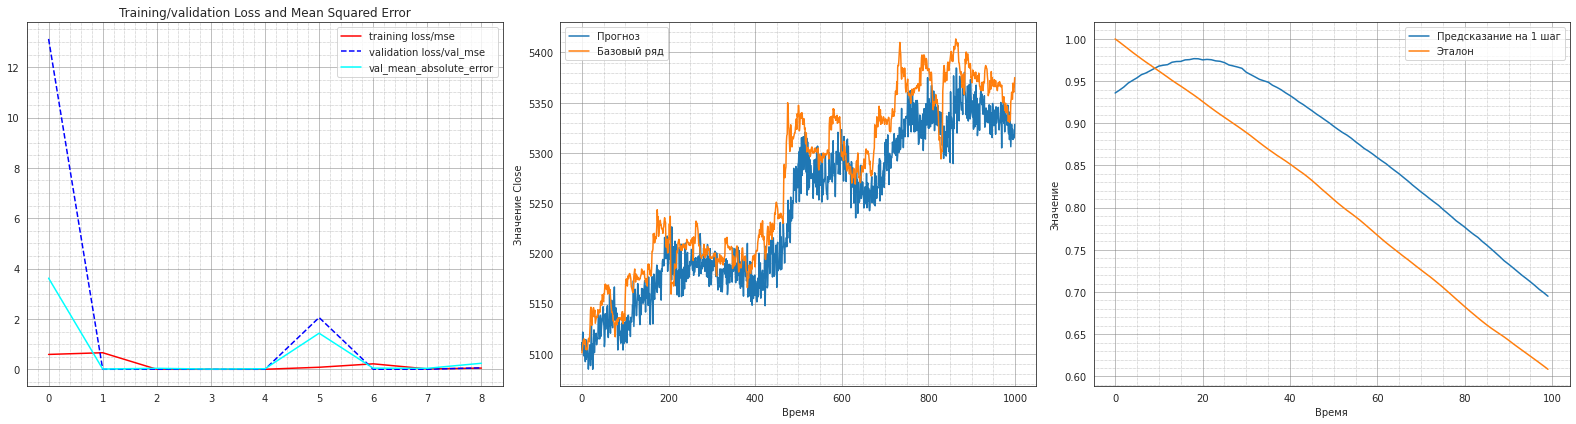

In [ ]:
if th.bigdata:
  # selection = ['bck_OP', 'dx2_VL', 'mul_OPVL', 'sub_MNCL']
  selection = ['dx2_MX', 'mul_OPMN', 'dx2_CL', 'dx2_VL', 'mul_MNVL', 'dx_MX', 'sub_OPCL', 'dx2_MN']
  # selection = ['mul_OPVL', 'bck_CL', 'abs_sub_MXMN', 'abs_sub_OPMX', 'mul_OPMN', 'mul_OPMX', 'mul_MXCL', 'dx2_MN']
  th.dataset_ready = False
  print (f'Selected columns:\n{selection}')
  kernel_values = [*range(1, len(selection)+len(th.base_cols)+1)]
  len_kernel_values = len(kernel_values)
  # print(kernel_values, len_kernel_values)
  th.choose_cols_data(selection)
else:
  kernel_values = [*range(1, len(th.base_cols)+1)]
  len_kernel_values = len(kernel_values)
  # print(kernel_values, len_kernel_values)
  th.choose_cols_data(th.base_cols)

if not th.dataset_ready:
  th.createdataset()

print (f'Train shape: ({th.trainDataGen[0][0].shape[1]}, {len_kernel_values})')
dataInput = Input(shape=(th.trainDataGen[0][0].shape[1], len_kernel_values))
# twin_filters = hp.Int(f'twin_filters', len_kernel_values, 400, step=len_kernel_values, default=13*len_kernel_values)
twin_filters = 13*len_kernel_values
conv_kernel_size = len_kernel_values

lstmWay = LSTM(twin_filters, return_sequences="True")(dataInput)
convWay = Conv1D(65, kernel_size=conv_kernel_size, activation='linear')(dataInput)

lstmConvWay = Conv1D(65,  kernel_size=conv_kernel_size, activation='sigmoid')(lstmWay)
convLstmWay = LSTM(twin_filters, return_sequences ="True")(convWay)

lstmWay = LSTM(twin_filters, return_sequences="True")(lstmWay)
convWay = Conv1D(65, kernel_size=conv_kernel_size, activation='linear')(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
# finWay = Dense(hp.Int(f'dense_filters', len_kernel_values, len_kernel_values*25, step=len_kernel_values, default=len_kernel_values*11), activation="linear")(finWay)
finWay = Dense(len_kernel_values*11, activation="linear")(finWay)
finWay = Dense(th.yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)
modelX.compile(
              optimizer=Adam(lr=1e-6),
              loss='mse',
              metrics=['mse'],
              )
# th.compile_model(modelX, 'best_model_base_DX_5')
# th = T5(data_df, '/content/drive/My Drive/Colab Notebooks/data/dz20/testing/pro', 'LSTM_DX_6', xLen=300, valLen=30000, trials=2)
# th.stack
# th.main(search_type='HYPERBAND')
th.stride = 10
th.xLen=300
th.valLen=30000
th.model_test(modelX, 'best_model_base_DX_6', EPOCHS=15, start_patience=5, LR=1e-6)
th.load_model_weigths(f'{th.directory}/best_model_base_DX_6.h5')
# th.history = savehistory
th.figureShow()

## PRO 2. Выводы:
1. Дополнительные данные, созданные из существующих, могут как добавить точности NN, так и снижать ее
2. Использование генетического алгоритма для выбора необходимых параметров NN (слои, активация, кол-во нейронов и пр), может также использоваться для селекции данных или групп данных
3. Селекция данных с помощью генетического алгоритма, позволяет существенно ускорить процесс поиска необходимой выборки
4. Несмотря на селекцию, имеет смысл добавлять не все сразу колонки отобранные при генетическом алгоритме, а делать это ступенчато и постепенно. Добавление 8 колонок только снизило результат, возможно необходимо, заново проводить оптимизацию по кол-ву нейронов и других параметров в слоях. Таким образом, становится очевидным, что селекцию данных надо проводить, на простейшей и быстрой модели в первую очередь.  
5. Проработку архитектуры имеет смысл проводить на небольшом наборе данных (уменьшенное "окно" или лучшее решение увеличение параметра stride). При этом необходимо учитывать, в случае использования stride, понижение точности 
6. В текущей модели lookback на 100 точек, не дал явного положительного результата, видимо требуется отдельная серия тестов 
7. Решение проблемы автокорреляции может лежать в нескольких плоскостях:
  - архитектуре
  - наборе подаваемых данных
  - подготовке подаваемых данных
  - использованиии специальной функции loss для снижения автокорреляции 
8. Несмотря на небольшой объем (по объему в мб) данных, обучение на датасетах с временными рядами, может занимать много времени, в зависимости от NN архитектуры и типов слоев
